In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2
import matplotlib.pyplot as plt

In [ ]:
import keras

models = []
for i in range(14):
    json_file = open('vgg2/model_' + str(i) + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    
    model_path = 'vgg2/model_' + str(i) + '.h5'  
    loaded_model.load_weights(model_path)
    print("Loaded model from disk")
    models.append(loaded_model)

In [ ]:
_BATCH_NORM_DECAY = 0.9
_BATCH_NORM_EPSILON = 1e-05
_LEAKY_RELU = 0.1
_ANCHORS = [(10, 13), (26, 30), (33, 23),
            (50, 61), (62, 45), (99, 119),
            (116, 90), (156, 198), (373, 326)]
_MODEL_SIZE = (416, 416)

In [5]:
def batch_norm(inputs, training, data_format):

    return tf.layers.batch_normalization(
        inputs=inputs, axis=1 if data_format == 'channels_first' else 3,
        momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON,
        scale=True, training=training)

def fixed_padding(inputs, kernel_size, data_format):
    pad_total = kernel_size - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg

    if data_format == 'channels_first':
        padded_inputs = tf.pad(inputs, [[0, 0], [0, 0],
                                        [pad_beg, pad_end],
                                        [pad_beg, pad_end]])
    else:
        padded_inputs = tf.pad(inputs, [[0, 0], [pad_beg, pad_end],
                                        [pad_beg, pad_end], [0, 0]])
    return padded_inputs

def conv2d_fixed_padding(inputs, filters, kernel_size, data_format, strides=1):
    if strides > 1:
        inputs = fixed_padding(inputs, kernel_size, data_format)

    d_format = data_format     
        
    return tf.layers.conv2d(
        inputs=inputs, filters=filters, kernel_size=kernel_size,
        strides=strides, padding=('SAME' if strides == 1 else 'VALID'),
        use_bias=False, data_format=d_format, reuse=False)

In [6]:
def darknet53_residual_block(inputs, filters, training, data_format,
                             strides=1):
    shortcut = inputs

    inputs = conv2d_fixed_padding(
        inputs, filters=filters, kernel_size=1, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(
        inputs, filters=2 * filters, kernel_size=3, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs += shortcut

    return inputs

def darknet53(inputs, training, data_format):
    inputs = conv2d_fixed_padding(inputs, filters=32, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    inputs = conv2d_fixed_padding(inputs, filters=64, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = darknet53_residual_block(inputs, filters=32, training=training,
                                      data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=128, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    
    for _ in range(2):
        inputs = darknet53_residual_block(inputs, filters=64,
                                          training=training,
                                          data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=256, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=128,
                                          training=training,
                                          data_format=data_format)

    route1 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=512, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    
    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=256,
                                          training=training,
                                          data_format=data_format)

    route2 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=1024, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(4):
        inputs = darknet53_residual_block(inputs, filters=512,
                                          training=training,
                                          data_format=data_format)

    return route1, route2, inputs

def yolo_convolution_block(inputs, filters, training, data_format):
    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    
    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    route = inputs

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    return route, inputs

In [7]:
def yolo_layer(inputs, n_classes, anchors, img_size, data_format):

    n_anchors = len(anchors)

    inputs = tf.layers.conv2d(inputs, filters=n_anchors * (5 + n_classes),
                              kernel_size=1, strides=1, use_bias=True,
                              data_format=data_format)
    
    shape = inputs.get_shape().as_list()
    grid_shape = shape[2:4] if data_format == 'channels_first' else shape[1:3]
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
    inputs = tf.reshape(inputs, [-1, n_anchors * grid_shape[0] * grid_shape[1],
                                 5 + n_classes])

    strides = (img_size[0] // grid_shape[0], img_size[1] // grid_shape[1])

    box_centers, box_shapes, confidence, classes = \
        tf.split(inputs, [2, 2, 1, n_classes], axis=-1)

    x = tf.range(grid_shape[0], dtype=tf.float32)
    y = tf.range(grid_shape[1], dtype=tf.float32)
    x_offset, y_offset = tf.meshgrid(x, y)
    x_offset = tf.reshape(x_offset, (-1, 1))
    y_offset = tf.reshape(y_offset, (-1, 1))
    x_y_offset = tf.concat([x_offset, y_offset], axis=-1)
    x_y_offset = tf.tile(x_y_offset, [1, n_anchors])
    x_y_offset = tf.reshape(x_y_offset, [1, -1, 2])
    box_centers = tf.nn.sigmoid(box_centers)
    box_centers = (box_centers + x_y_offset) * strides
    
    anchors = tf.tile(anchors, [grid_shape[0] * grid_shape[1], 1])
    box_shapes = tf.exp(box_shapes) * tf.to_float(anchors)

    confidence = tf.nn.sigmoid(confidence)

    classes = tf.nn.sigmoid(classes)

    inputs = tf.concat([box_centers, box_shapes,
                        confidence, classes], axis=-1)

    return inputs

In [8]:
def upsample(inputs, out_shape, data_format):
    """Upsamples to `out_shape` using nearest neighbor interpolation."""
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
        new_height = out_shape[3]
        new_width = out_shape[2]
    else:
        new_height = out_shape[2]
        new_width = out_shape[1]

    inputs = tf.image.resize_nearest_neighbor(inputs, (new_height, new_width))

    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 3, 1, 2])

    return inputs

In [9]:
def build_boxes(inputs):
    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)

    top_left_x = center_x - width / 2
    top_left_y = center_y - height / 2
    bottom_right_x = center_x + width / 2
    bottom_right_y = center_y + height / 2

    boxes = tf.concat([top_left_x, top_left_y,
                       bottom_right_x, bottom_right_y,
                       confidence, classes], axis=-1)

    return boxes

def non_max_suppression(inputs, n_classes, max_output_size, iou_threshold,
                        confidence_threshold):
    """Performs non-max suppression separately for each class.

    Args:
        inputs: Tensor input.
        n_classes: Number of classes.
        max_output_size: Max number of boxes to be selected for each class.
        iou_threshold: Threshold for the IOU.
        confidence_threshold: Threshold for the confidence score.
    Returns:
        A list containing class-to-boxes dictionaries
            for each sample in the batch.
    """
    batch = tf.unstack(inputs)
    boxes_dicts = []
    for boxes in batch:
        boxes = tf.boolean_mask(boxes, boxes[:, 4] > confidence_threshold)
        classes = tf.argmax(boxes[:, 5:], axis=-1)
        classes = tf.expand_dims(tf.to_float(classes), axis=-1)
        boxes = tf.concat([boxes[:, :5], classes], axis=-1)
        
        boxes_dict = dict()
        for cls in range(n_classes):
            mask = tf.equal(boxes[:, 5], cls)
            mask_shape = mask.get_shape()
            if mask_shape.ndims != 0:
                class_boxes = tf.boolean_mask(boxes, mask)
                boxes_coords, boxes_conf_scores, _ = tf.split(class_boxes,
                                                              [4, 1, -1],
                                                              axis=-1)
                boxes_conf_scores = tf.reshape(boxes_conf_scores, [-1])
                indices = tf.image.non_max_suppression(boxes_coords,
                                                       boxes_conf_scores,
                                                       max_output_size,
                                                       iou_threshold)
                class_boxes = tf.gather(class_boxes, indices)
                boxes_dict[cls] = class_boxes[:, :5]

        boxes_dicts.append(boxes_dict)

    return boxes_dicts

In [10]:
class Yolo_v3:
    """Yolo v3 model class."""

    def __init__(self, n_classes, model_size, max_output_size, iou_threshold,
                 confidence_threshold, data_format=None):
        """Creates the model.

        Args:
            n_classes: Number of class labels.
            model_size: The input size of the model.
            max_output_size: Max number of boxes to be selected for each class.
            iou_threshold: Threshold for the IOU.
            confidence_threshold: Threshold for the confidence score.
            data_format: The input format.

        Returns:
            None.
        """
        if not data_format:
            if tf.test.is_built_with_cuda():
                data_format = 'channels_first'
            else:
                data_format = 'channels_last'
                
        self.n_classes = n_classes
        self.model_size = model_size
        self.max_output_size = max_output_size
        self.iou_threshold = iou_threshold
        self.confidence_threshold = confidence_threshold
        self.data_format = data_format

    def __call__(self, inputs, training):
        """Add operations to detect boxes for a batch of input images.

        Args:
            inputs: A Tensor representing a batch of input images.
            training: A boolean, whether to use in training or inference mode.

        Returns:
            A list containing class-to-boxes dictionaries
                for each sample in the batch.
        """
        with tf.variable_scope('yolo_v3_model'):
            if self.data_format == 'channels_first':
                inputs = tf.transpose(inputs, [0, 3, 1, 2])
                
            inputs = inputs / 255

            route1, route2, inputs = darknet53(inputs, training, self.data_format)

            route, inputs = yolo_convolution_block(inputs, 512, training, self.data_format)
            detect1 = yolo_layer(inputs, self.n_classes, _ANCHORS[6:9], self.model_size, self.data_format)
            
            inputs = conv2d_fixed_padding(route, 256, 1, self.data_format)
            inputs = batch_norm(inputs, training, data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha = _LEAKY_RELU)
            
            upsample_size = route2.get_shape().as_list()
            
            inputs = upsample(inputs, upsample_size, self.data_format)
            
            axis = 1 if self.data_format == 'channels_first' else 3
            
            inputs = tf.concat([inputs, route2], axis=axis)
            route, inputs = yolo_convolution_block(inputs, 256, training, self.data_format)
            detect2 = yolo_layer(inputs, self.n_classes, _ANCHORS[3:6], self.model_size, self.data_format)
            
            inputs = conv2d_fixed_padding(route, 128, 1, self.data_format)
            inputs = batch_norm(inputs, training, self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            
            upsample_size = route1.get_shape().as_list()
            
            inputs = upsample(inputs, upsample_size, self.data_format)
            inputs = tf.concat([inputs, route1], axis=axis)
            route, inputs = yolo_convolution_block(inputs, 128, training, self.data_format)
            detect3 = yolo_layer(inputs, self.n_classes, _ANCHORS[0:3], self.model_size, self.data_format)
            
            inputs = tf.concat([detect1, detect2, detect3], axis=1)

            inputs = build_boxes(inputs)

            boxes_dicts = non_max_suppression(
                inputs, n_classes=self.n_classes,
                max_output_size=self.max_output_size,
                iou_threshold=self.iou_threshold,
                confidence_threshold=self.confidence_threshold)

            return boxes_dicts

In [11]:
def load_images(img_names, model_size):
    imgs = []

    for img_name in img_names:
        img = Image.open(img_name)
        img = img.resize(size=model_size)
        img = np.array(img, dtype=np.float32)
        img = np.expand_dims(img, axis=0)
        imgs.append(img)

    imgs = np.concatenate(imgs)

    return imgs

def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names


def draw_boxes(img_names, boxes_dicts, class_names, model_size):
    """Draws detected boxes.

    Args:
        img_names: A list of input images names.
        boxes_dict: A class-to-boxes dictionary.
        class_names: A class names list.
        model_size: The input size of the model.

    Returns:
        None.
    """
    
    all_coordinates = []
    
    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    for num, img_name, boxes_dict in zip(range(len(img_names)), img_names,
                                         boxes_dicts):
        
        coordinates = []
        img = Image.open(img_name)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font='Roboto-Medium.ttf',
                                  size=(img.size[0] + img.size[1]) // 100)
        resize_factor = \
            (img.size[0] / model_size[0], img.size[1] / model_size[1])
        for cls in range(len(class_names)):
            if class_names[cls] == "person":
                boxes = boxes_dict[cls]
                if np.size(boxes) != 0:
                    color = colors[cls]
                    for box in boxes:
                        xy, confidence = box[:4], box[4]
                        xy = [xy[i] * resize_factor[i % 2] for i in range(4)]
                        x0, y0 = xy[0], xy[1]
                        
                        thickness = (img.size[0] + img.size[1]) // 500
                        
                        h = xy[3] - xy[1]
                        w = xy[2] - xy[0]
                        
                        xy[0] = xy[0] - w//10 
                        xy[1] = xy[1] - h//10 
                        xy[2] = xy[2] + w//10 
                        xy[3] = xy[3] + h//10 
                        
                        x0 = xy[0]
                        y0 = xy[1]
                        
                        coordinates.append(xy)
                        
                        for t in np.linspace(0, 1, thickness):
                            xy[0], xy[1] = xy[0] + t, xy[1] + t
                            xy[2], xy[3] = xy[2] - t, xy[3] - t
                            draw.rectangle(xy, outline=tuple(color))
                        text = '{} {:.1f}%'.format(class_names[cls],
                                                   confidence * 100)
                        text_size = draw.textsize(text, font=font)
                        draw.rectangle(
                            [x0, y0 - text_size[1], x0 + text_size[0], y0],
                            fill=tuple(color))
                        draw.text((x0, y0 - text_size[1]), text, fill='black',
                                  font=font)

        all_coordinates.append(coordinates)
        display(img)
        
    return all_coordinates

In [12]:
def load_weights(variables, file_name):
    """Reshapes and loads official pretrained Yolo weights.

    Args:
        variables: A list of tf.Variable to be assigned.
        file_name: A name of a file containing weights.

    Returns:
        A list of assign operations.
    """
    with open(file_name, "rb") as f:
        # Skip first 5 values containing irrelevant info
        np.fromfile(f, dtype=np.int32, count=5)
        weights = np.fromfile(f, dtype=np.float32)

        assign_ops = []
        ptr = 0

        # Load weights for Darknet part.
        # Each convolution layer has batch normalization.
        for i in range(52):
            conv_var = variables[5 * i]
            gamma, beta, mean, variance = variables[5 * i + 1:5 * i + 5]
            batch_norm_vars = [beta, gamma, mean, variance]

            for var in batch_norm_vars:
                shape = var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(shape)
                ptr += num_params
                assign_ops.append(tf.assign(var, var_weights))

            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

        # Loading weights for Yolo part.
        # 7th, 15th and 23rd convolution layer has biases and no batch norm.
        ranges = [range(0, 6), range(6, 13), range(13, 20)]
        unnormalized = [6, 13, 20]
        for j in range(3):
            for i in ranges[j]:
                current = 52 * 5 + 5 * i + j * 2
                conv_var = variables[current]
                gamma, beta, mean, variance =  \
                    variables[current + 1:current + 5]
                batch_norm_vars = [beta, gamma, mean, variance]

                for var in batch_norm_vars:
                    shape = var.shape.as_list()
                    num_params = np.prod(shape)
                    var_weights = weights[ptr:ptr + num_params].reshape(shape)
                    ptr += num_params
                    assign_ops.append(tf.assign(var, var_weights))
                    
                shape = conv_var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(
                    (shape[3], shape[2], shape[0], shape[1]))
                var_weights = np.transpose(var_weights, (2, 3, 1, 0))
                ptr += num_params
                assign_ops.append(tf.assign(conv_var, var_weights))

            bias = variables[52 * 5 + unnormalized[j] * 5 + j * 2 + 1]
            shape = bias.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(shape)
            ptr += num_params
            assign_ops.append(tf.assign(bias, var_weights))

            conv_var = variables[52 * 5 + unnormalized[j] * 5 + j * 2]
            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

    return assign_ops

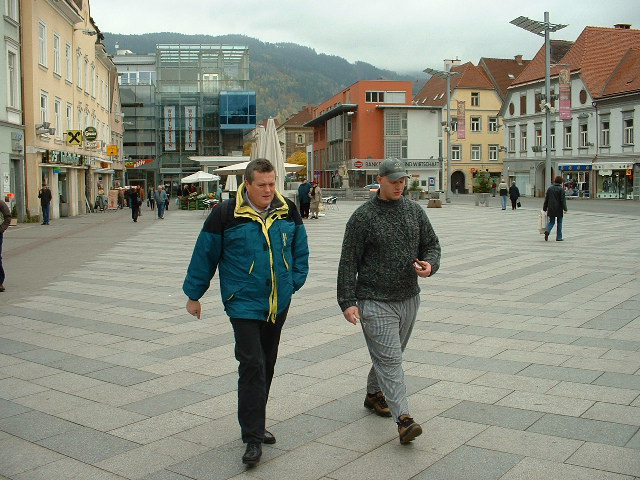

In [13]:
img_names = ['INRIAPerson/Train/pos/person_302.png']
for img in img_names: display(Image.open(img))

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.


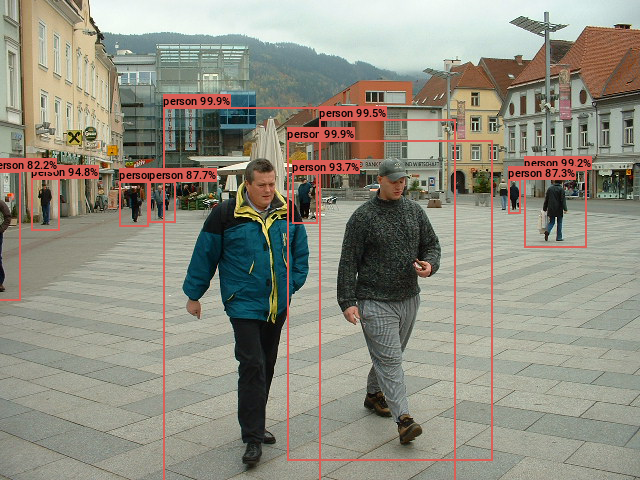

In [14]:
batch_size = len(img_names)
batch = load_images(img_names, model_size=_MODEL_SIZE)
class_names = load_class_names('coco.names')
n_classes = len(class_names)
max_output_size = 10
iou_threshold = 0.65
confidence_threshold = 0.65

model = Yolo_v3(n_classes=n_classes, model_size=_MODEL_SIZE,
                max_output_size=max_output_size,
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold)

inputs = tf.placeholder(tf.float32, [batch_size, 416, 416, 3])

detections = model(inputs, training=False)

model_vars = tf.global_variables(scope='yolo_v3_model')
assign_ops = load_weights(model_vars, 'yolov3.weights')

with tf.Session() as sess:
    sess.run(assign_ops)
    detection_result = sess.run(detections, feed_dict={inputs: batch})
    
coordinates = draw_boxes(img_names, detection_result, class_names, _MODEL_SIZE)

In [15]:
def get_roi(image_names, all_coordinates):
    
    all_roi = []
    for (i, img_name) in enumerate(image_names):
        img = Image.open(img_name)
        coordinates = all_coordinates[i]
        image_roi = []
        for box in coordinates:
            roi = np.asarray(img)[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
            image_roi.append(roi)
        all_roi.append(image_roi)
    
    return all_roi

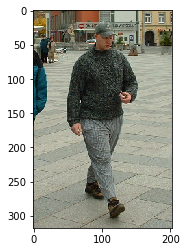

In [24]:
all_roi = get_roi(img_names, coordinates)
test = []
img = all_roi[0][0]
resized = cv2.resize(img, (150, 150), interpolation = cv2.INTER_AREA)
test.append(resized)
pred = []
plt.imshow(img)

In [25]:
def resize_images(imgs, y):
    images = []
    for i, img in enumerate(imgs[:2000]):
        y[i][0] = (y[i][0]/img.shape[1])*150
        y[i][1] = (y[i][1]/img.shape[0])*150
        resized = cv2.resize(img, (150, 150), interpolation = cv2.INTER_AREA)
        images.append(resized)
    labels = y
    return np.array(images), labels
        
def draw_joints(image, labels):
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    for i in range(14):
        circ = Circle((labels[i][0][0], labels[i][0][1]), 4)
        ax.add_patch(circ)
    ax.imshow(image)
    plt.show()

In [26]:
for i in range(14):
    score = models[i].predict(np.array(test))
    pred.append(score)

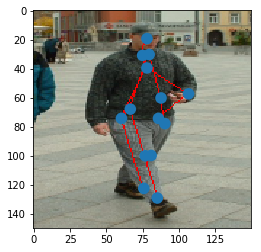

In [27]:
from PIL import Image, ImageDraw
from matplotlib import cm

i = resized/255.

im = Image.fromarray(resized)
draw = ImageDraw.Draw(im) 
draw.line((pred[13][0][0],pred[13][0][1], pred[12][0][0],pred[12][0][1]), fill=500)
draw.line((pred[9][0][0],pred[9][0][1], pred[12][0][0],pred[12][0][1]), fill=500)
draw.line((pred[8][0][0],pred[8][0][1], pred[12][0][0],pred[12][0][1]), fill=500)
draw.line((pred[9][0][0],pred[9][0][1], pred[3][0][0],pred[3][0][1]), fill=500)
draw.line((pred[8][0][0],pred[8][0][1], pred[2][0][0],pred[2][0][1]), fill=500)
draw.line((pred[3][0][0],pred[3][0][1], pred[2][0][0],pred[2][0][1]), fill=500)
draw.line((pred[3][0][0],pred[3][0][1], pred[5][0][0],pred[5][0][1]), fill=500)
draw.line((pred[0][0][0],pred[0][0][1], pred[2][0][0],pred[2][0][1]), fill=500)
draw.line((pred[9][0][0],pred[9][0][1], pred[10][0][0],pred[10][0][1]), fill=500)
draw.line((pred[8][0][0],pred[8][0][1], pred[7][0][0],pred[7][0][1]), fill=500)
draw.line((pred[6][0][0],pred[6][0][1], pred[7][0][0],pred[7][0][1]), fill=500)
draw.line((pred[10][0][0],pred[10][0][1], pred[11][0][0],pred[11][0][1]), fill=500)

a = []
a.append(pred[11])
arr = np.array(im)
from matplotlib.patches import Circle
draw_joints(arr, np.array(pred))